In [ ]:
# SIMULATION SETUP

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from mobotpy.integration import rk_four
from mobotpy.models import FourWheelSteered

# Set the simulation time [s] and the sample period [s]
SIM_TIME = 20.0
T = 0.1

# Create an array of time values [s]
t = np.arange(0.0, SIM_TIME, T)
N = np.size(t)

In [ ]:
# VEHICLE SETUP

# Set the wheelbase and track of the vehicle [m]
ELL_W = 2.50
ELL_T = 1.75

# Let's now use the class Ackermann for plotting
vehicle = FourWheelSteered(ELL_W, ELL_T)

In [ ]:
# CREATE A MAP OF FEATURES

# Set the minimum number of features in the map that achieves observability
N_FEATURES = 2

# Set the size [m] of a square map
D_MAP = 30.0

# Create a map of randomly placed feature locations
f_map = np.zeros((2, N_FEATURES))
for i in range(0, N_FEATURES):
    f_map[:, i] = D_MAP * (np.random.rand(2) - 0.5)

In [ ]:
# FUNCTION TO MODEL RANGE TO FEATURES


def range_sensor(x, f_map):
    """
    Function to model the range sensor.

    Parameters
    ----------
    x : ndarray
        An array of length 2 representing the robot's position.
    f_map : ndarray
        An array of size (2, N_FEATURES) containing map feature locations.

    Returns
    -------
    ndarray
        The range to each feature in the map.
    """

    # Compute the range to each feature from the current robot position
    r = np.zeros(N_FEATURES)
    for j in range(0, N_FEATURES):
        r[j] = np.sqrt((f_map[0, j] - x[0]) ** 2 + (f_map[1, j] - x[1]) ** 2)

    # Return the array of measurements
    return r

In [ ]:
# FUNCTION TO IMPLEMENT THE OBSERVER


def fws_observer(q, u, r, f_map):
    """
    Function to implement an observer for the robot's pose.

    Parameters
    ----------
    q : ndarray
        An array of length 4 representing the (last) robot's pose.
    u : ndarray
        An array of length 2 representing the robot's inputs.
    r : ndarray
        An array of length N_FEATURES representing the range to each feature.
    f_map : ndarray
        An array of size (2, N_FEATURES) containing map feature locations.

    Returns
    -------
    ndarray
        The estimated pose of the robot.
    """

    # Compute the Jacobian matrices (i.e., linearize about current estimate)
    F = np.zeros((4, 4))
    F = np.eye(4) + T * np.array(
        [
            [
                0,
                0,
                -u[0] * np.sin(q[2]) * np.cos(q[3]),
                -u[0] * np.cos(q[2]) * np.sin(q[3]),
            ],
            [
                0,
                0,
                u[0] * np.cos(q[2]) * np.cos(q[3]),
                -u[0] * np.sin(q[2]) * np.sin(q[3]),
            ],
            [0, 0, 0, u[0] * 1.0 / (0.5 * ELL_W) * np.cos(q[3])],
            [0, 0, 0, 0],
        ]
    )
    H = np.zeros((N_FEATURES, 4))
    for j in range(0, N_FEATURES):
        H[j, :] = np.array(
            [
                -(f_map[0, j] - q[0]) / range_sensor(q, f_map)[j],
                -(f_map[1, j] - q[1]) / range_sensor(q, f_map)[j],
                0,
                0,
            ]
        )

    # Check the observability of this system
    observability_matrix = H
    for j in range(1, 4):
        observability_matrix = np.concatenate(
            (observability_matrix, H @ np.linalg.matrix_power(F, j)), axis=0
        )
    if np.linalg.matrix_rank(observability_matrix) < 4:
        raise ValueError("System is not observable!")

    # Set the desired poles at lambda_z (change these as desired)
    lambda_z = np.array([0.8, 0.7, 0.6, 0.5])
    # Compute the observer gain
    L = signal.place_poles(F.T, H.T, lambda_z).gain_matrix.T
    # Use the pseudo-inverse to compute the observer gain (when overdetermined)
    # L = signal.place_poles(F.T, np.eye(4), lambda_z).gain_matrix @ np.linalg.pinv(H)

    # Predict the state using the inputs and the robot's kinematic model
    q_new = q + T * vehicle.f(q, u)
    # Correct the state using the range measurements
    q_new = q_new + L @ (r - range_sensor(q, f_map))

    # Return the estimated state
    return q_new

In [ ]:
# RUN SIMULATION

# Initialize arrays that will be populated with our inputs and states
x = np.zeros((4, N))
u = np.zeros((2, N))
x_hat = np.zeros((4, N))

# Set the initial pose [m, m, rad, rad], velocities [m/s, rad/s]
x[0, 0] = -5.0
x[1, 0] = -3.0
x[2, 0] = np.pi / 2.0
x[3, 0] = 0.0
u[0, 0] = 5.0
u[1, 0] = 0

# Just drive around and try to localize!
for k in range(1, N):
    # Measure the actual range to each feature
    r = range_sensor(x[:, k - 1], f_map)
    # Use the range measurements to estimate the robot's state
    x_hat[:, k] = fws_observer(x_hat[:, k - 1], u[:, k - 1], r, f_map)
    # Choose some new inputs
    u[0, k] = 2.0
    u[1, k] = -0.1 * np.sin(1 * t[k])
    # Simulate the robot's motion
    x[:, k] = rk_four(vehicle.f, x[:, k - 1], u[:, k - 1], T)

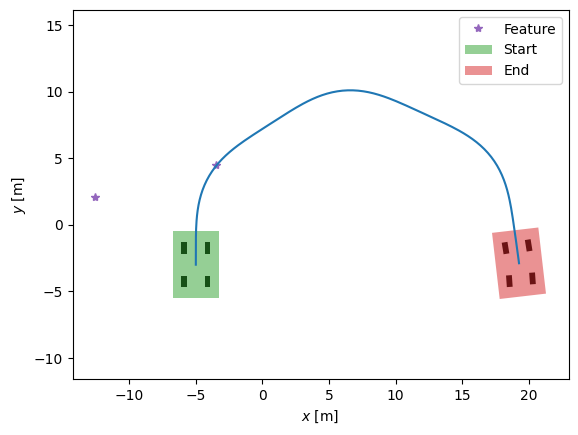

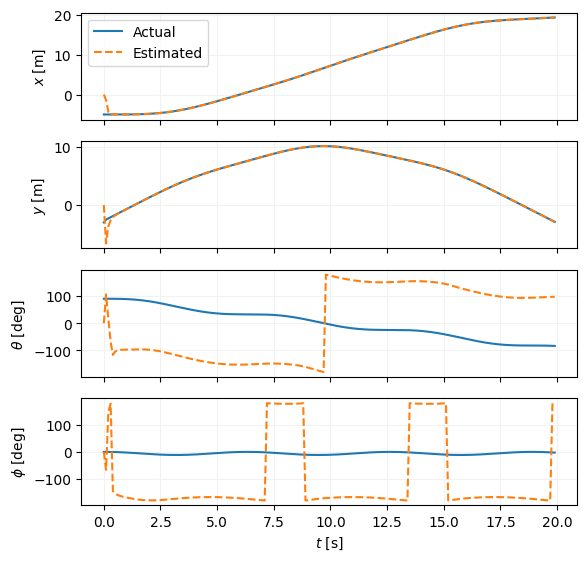

In [ ]:
# MAKE SOME PLOTS


# Function to wrap angles to [-pi, pi]
def wrap_to_pi(angle):
    """Wrap angles to the range [-pi, pi]."""
    return (angle + np.pi) % (2 * np.pi) - np.pi


# Change some plot settings (optional)
plt.rc("text", usetex=False)
plt.rc("text.latex", preamble=r"\usepackage{cmbright,amsmath,bm}")
plt.rc("savefig", format="pdf")
plt.rc("savefig", bbox="tight")

# Plot the position of the vehicle in the plane
fig1 = plt.figure(1)
plt.plot(f_map[0, :], f_map[1, :], "C4*", label="Feature")
plt.plot(x[0, :], x[1, :])
plt.axis("equal")
X_BL, Y_BL, X_BR, Y_BR, X_FL, Y_FL, X_FR, Y_FR, X_BD, Y_BD = vehicle.draw(x[:, 0])
plt.fill(X_BL, Y_BL, "k")
plt.fill(X_BR, Y_BR, "k")
plt.fill(X_FR, Y_FR, "k")
plt.fill(X_FL, Y_FL, "k")
plt.fill(X_BD, Y_BD, "C2", alpha=0.5, label="Start")
X_BL, Y_BL, X_BR, Y_BR, X_FL, Y_FL, X_FR, Y_FR, X_BD, Y_BD = vehicle.draw(x[:, N - 1])
plt.fill(X_BL, Y_BL, "k")
plt.fill(X_BR, Y_BR, "k")
plt.fill(X_FR, Y_FR, "k")
plt.fill(X_FL, Y_FL, "k")
plt.fill(X_BD, Y_BD, "C3", alpha=0.5, label="End")
plt.xlabel(r"$x$ [m]")
plt.ylabel(r"$y$ [m]")
plt.legend()

# Plot the states as a function of time
fig2 = plt.figure(2)
fig2.set_figheight(6.4)
ax2a = plt.subplot(411)
plt.plot(t, x[0, :], "C0", label="Actual")
plt.plot(t, x_hat[0, :], "C1--", label="Estimated")
plt.grid(color="0.95")
plt.ylabel(r"$x$ [m]")
plt.setp(ax2a, xticklabels=[])
plt.legend()
ax2b = plt.subplot(412)
plt.plot(t, x[1, :], "C0", label="Actual")
plt.plot(t, x_hat[1, :], "C1--", label="Estimated")
plt.grid(color="0.95")
plt.ylabel(r"$y$ [m]")
plt.setp(ax2b, xticklabels=[])
ax2c = plt.subplot(413)
plt.plot(t, wrap_to_pi(x[2, :]) * 180.0 / np.pi, "C0", label="Actual")
plt.plot(t, wrap_to_pi(x_hat[2, :]) * 180.0 / np.pi, "C1--", label="Estimated")
plt.ylabel(r"$\theta$ [deg]")
plt.grid(color="0.95")
plt.setp(ax2c, xticklabels=[])
ax2d = plt.subplot(414)
plt.plot(t, wrap_to_pi(x[3, :]) * 180.0 / np.pi, "C0", label="Actual")
plt.plot(t, wrap_to_pi(x_hat[3, :]) * 180.0 / np.pi, "C1--", label="Estimated")
plt.ylabel(r"$\phi$ [deg]")
plt.grid(color="0.95")
plt.xlabel(r"$t$ [s]")

# Show all the plots to the screen
plt.show()